In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

df_diabetes = pd.DataFrame(X, columns=diabetes.feature_names)
df_diabetes['target'] = y
df_diabetes.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
param_grids = {
    'rbf': {
        'model': SVR(kernel='rbf'),
        'params': {'C': [10, 100, 1000], 'gamma': [0.01, 0.1, 'scale', 'auto'], 'epsilon': [0.01, 0.1, 0.5, 1]}
    },
    'linear': {
        'model': SVR(kernel='linear'),
        'params': {'C': [1, 10, 100, 1000], 'epsilon': [0.01, 0.1, 0.5, 1]}
    },
    'poly': {
        'model': SVR(kernel='poly'),
        'params': {'C': [10, 100, 1000], 'degree': [2, 3], 'epsilon': [0.01, 0.1], 'coef0': [0, 1], 'gamma': ['scale', 0.01]}
    }
}

best_models = {}
best_params = {}

for kernel, config in param_grids.items():
    print(f"Training {kernel.upper()} kernel model...")
    grid = GridSearchCV(config['model'], config['params'], cv=4,
                        scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_models[kernel] = grid.best_estimator_
    best_params[kernel] = grid.best_params_
    print(f"Best parameters for {kernel.upper()}: {grid.best_params_}\n")


Training RBF kernel model...
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters for RBF: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}

Training LINEAR kernel model...
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best parameters for LINEAR: {'C': 1, 'epsilon': 1}

Training POLY kernel model...
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters for POLY: {'C': 100, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01}



In [44]:
import time
timing_results = []

for kernel, params in best_params.items():
    model = SVR(kernel=kernel, **params)
    print(model)
    
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    timing_results.append({
        'Kernel': kernel,
        'Training Time (seconds)': training_time
    })
    
    print(f"{kernel} kernel training time: {training_time:.4f} seconds\n")

# Create a DataFrame with timing results
timing_df = pd.DataFrame(timing_results)
timing_df.head()

SVR(C=100, epsilon=0.01, gamma=0.01)
rbf kernel training time: 0.0080 seconds

SVR(C=1, epsilon=1, kernel='linear')
linear kernel training time: 0.0050 seconds

SVR(C=100, coef0=1, degree=2, gamma=0.01, kernel='poly')
poly kernel training time: 0.0040 seconds



,Kernel,Training Time (seconds)
0,rbf,0.007997
1,linear,0.005003
2,poly,0.003998


In [45]:
import sys

memory_results = []

for kernel, model in best_models.items():
    # support vectors memory (the actual training data the model stores)
    support_vectors_size = sys.getsizeof(model.support_vectors_) if hasattr(model, 'support_vectors_') else 0
    
    # dual coefficients memory
    dual_coef_size = sys.getsizeof(model.dual_coef_) if hasattr(model, 'dual_coef_') else 0
    
    # support indices memory
    support_size = sys.getsizeof(model.support_) if hasattr(model, 'support_') else 0
    
    total_memory_bytes = support_vectors_size + dual_coef_size + support_size
    total_memory_mb = total_memory_bytes / (1024 * 1024)
    
    # Number of support vectors (shows model complexity)
    n_support_vectors = len(model.support_) if hasattr(model, 'support_') else 0
    
    memory_results.append({
        'Kernel': kernel,
        'Model Size (MB)': total_memory_mb,
        'Support Vectors Count': n_support_vectors,
        'Support Vectors Size (bytes)': support_vectors_size,
        'Total Memory (bytes)': total_memory_bytes
    })

memory_df = pd.DataFrame(memory_results)
memory_df.head()

,Kernel,Model Size (MB),Support Vectors Count,Support Vectors Size (bytes),Total Memory (bytes)
0,rbf,0.031322,353,28368,32844
1,linear,0.031147,351,28208,32660
2,poly,0.031235,352,28288,32752


In [46]:
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    results.append({
        'Kernel': name,
        'R^2 Score': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df.head()

,Kernel,R^2 Score,MSE
0,rbf,0.569828,2977.579636
1,linear,0.538904,3191.629710
2,poly,0.558172,3058.260331


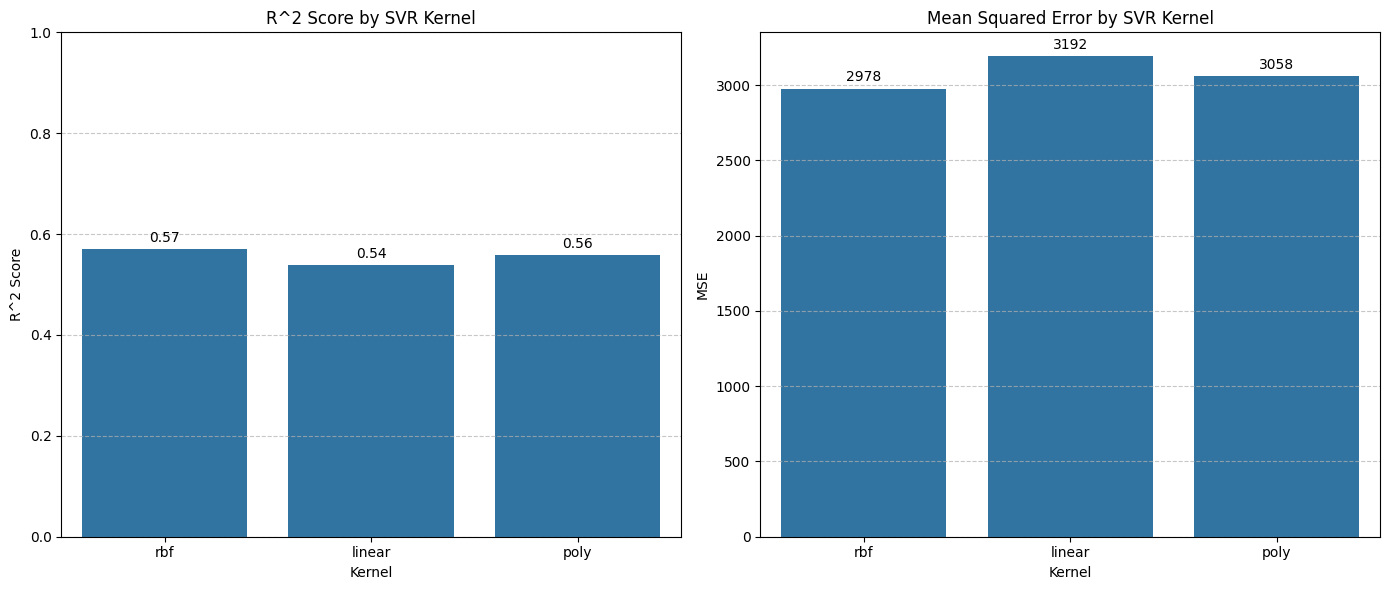

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=results_df, x='Kernel', y='R^2 Score', ax=axes[0])
axes[0].set_title('R^2 Score by SVR Kernel')
axes[0].set_ylim(0, 1)
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', padding=3)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(data=results_df, x='Kernel', y='MSE', ax=axes[1])
axes[1].set_title('Mean Squared Error by SVR Kernel')
axes[1].bar_label(axes[1].containers[0], fmt='%.0f', padding=3)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

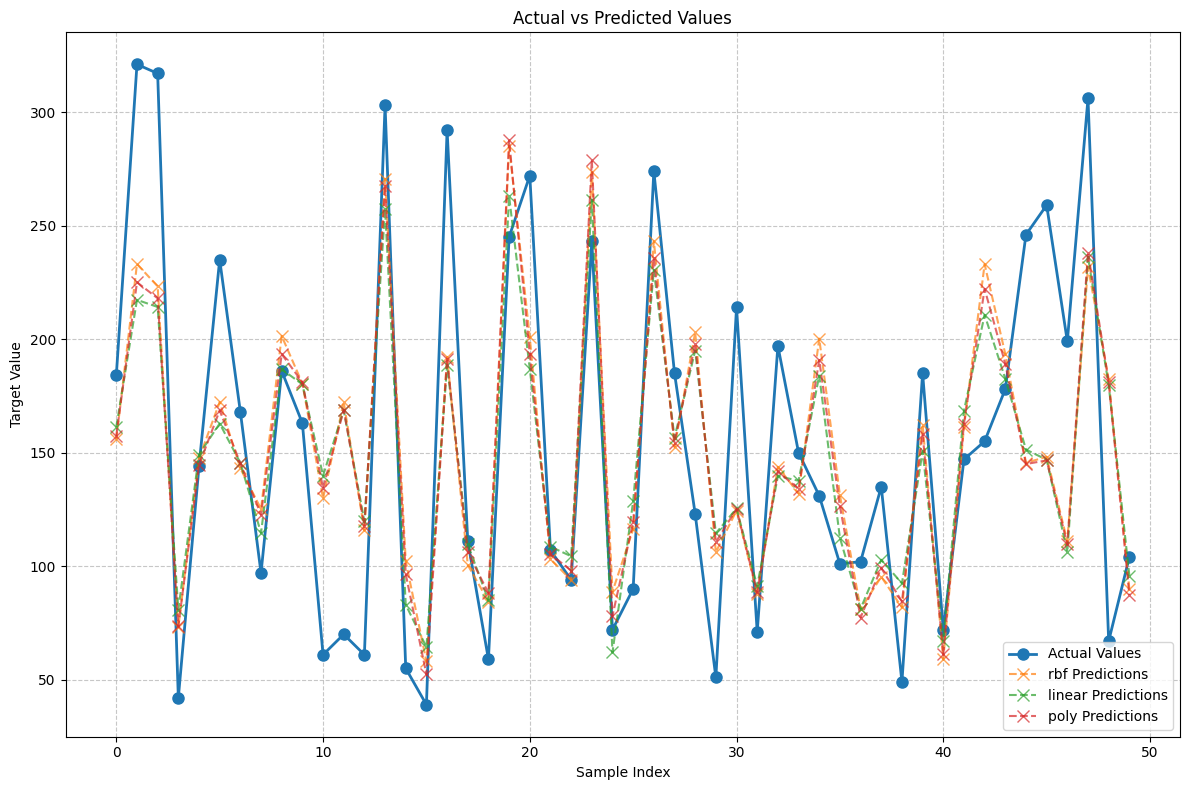

In [48]:
plt.figure(figsize=(12, 8))
    
# Get random subset of data for clearer visualization
indices = np.random.choice(range(len(y_test)), min(50, len(y_test)), replace=False)
x_indices = range(len(indices))
    
# Plot actual values
plt.plot(x_indices, y_test[indices], 'o-', label='Actual Values', linewidth=2, markersize=8)
    
# Plot predictions for each model
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled[indices])
    plt.plot(x_indices, y_pred, 'x--', label=f'{name} Predictions', alpha=0.7, markersize=8)
    
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()